## Con colores.

In [3]:
import tensorflow as tf
import numpy as np
import cv2

# ----------------------------
# Par√°metros de imagen
# ----------------------------
img_height = 224
img_width  = 224
batch_size = 32

# ----------------------------
# Rutas de los datasets
# ----------------------------
train_dir = "data/train"
test_dir  = "data/test"

# ----------------------------
# Funciones de preprocesado
# ----------------------------
def apply_heatmap_safe(img_tensor):
    img = img_tensor.numpy()
    img = (img * 255).astype('uint8')
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    heatmap = cv2.applyColorMap(img_gray, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (img_width, img_height))
    heatmap = heatmap.astype('float32') / 255.0
    return heatmap

def preprocess_with_heatmap(img, label):
    img = tf.image.resize(img, [img_height, img_width])
    img = img / 255.0

    def heat():
        return tf.py_function(apply_heatmap_safe, [img], Tout=tf.float32)

    # 40% de im√°genes en heatmap
    img_final = tf.cond(tf.random.uniform([]) < 0.4, heat, lambda: img)
    img_final.set_shape([img_height, img_width, 3])
    return img_final, label

# ----------------------------
# Cargar dataset de entrenamiento
# ----------------------------
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    batch_size=None
)

# Crear validaci√≥n a partir del train (80% train, 20% val)
train_size = int(0.8 * len(full_train_ds))
train_ds = full_train_ds.take(train_size)
val_ds   = full_train_ds.skip(train_size)

# Aplicar preprocesado con heatmaps
train_ds = train_ds.map(preprocess_with_heatmap, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess_with_heatmap, num_parallel_calls=tf.data.AUTOTUNE)

# Preparar batches y prefetch
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# Dataset de test
# ----------------------------
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    shuffle=False,
    batch_size=None
)

test_ds = test_ds.map(preprocess_with_heatmap, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("‚úÖ Dataset listo con 40% de im√°genes en heatmap")

Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
‚úÖ Dataset listo con 40% de im√°genes en heatmap


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import cv2


# ----------------------------
# Calcular pesos de clase para balancear
# ----------------------------
y_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# ----------------------------
# Crear modelo CNN (como tu versi√≥n original)
# ----------------------------
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ----------------------------
# Entrenamiento
# ----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=22,
    class_weight=class_weights
)

# ----------------------------
# Evaluaci√≥n en test
# ----------------------------
test_loss, test_acc = model.evaluate(test_ds)
print(f"‚úÖ Precisi√≥n en test: {test_acc:.2f}")

# ----------------------------
# Gr√°ficas de Accuracy y Loss
# ----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title("Precisi√≥n del modelo")
plt.xlabel("√âpocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title("Evoluci√≥n de la p√©rdida")
plt.xlabel("√âpocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ----------------------------
# Matriz de confusi√≥n y reporte
# ----------------------------
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

# ----------------------------
# Mostrar 5 im√°genes aleatorias con predicci√≥n
# ----------------------------
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
   
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow(images[idx].numpy())
        plt.axis("off")
        color_warning = "red" if preds_classes[idx] == 1 else "green"
        plt.title(f"{class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color_warning)
plt.show()

# ----------------------------
# Guardar modelo
# ----------------------------
model.save("modelo_cnn.h5")
print("‚úÖ Modelo guardado como modelo_cnn.h5")

Class weights: {0: np.float64(0.9427579365079365), 1: np.float64(1.0646426170737173)}
Epoch 1/22


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  1/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12:38 3s/step - accuracy: 0.6875 - loss: 0.6698

KeyboardInterrupt: 

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 87ms/step


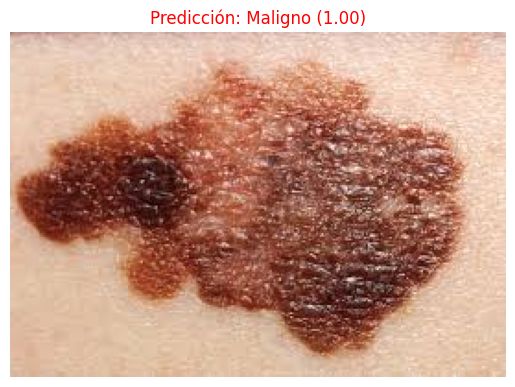

üëâ Resultado: Maligno con probabilidad 1.00


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Funci√≥n para analizar imagen
# ============================
def analizar_imagen(ruta_imagen, model, img_height=224, img_width=224, threshold=0.4):
    # Cargar la imagen
    img = tf.keras.utils.load_img(ruta_imagen, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)

    # Normalizar a [0,1]
    img_array = img_array / 255.0

    # A√±adir dimensi√≥n batch
    img_array = np.expand_dims(img_array, axis=0)

    # Predicci√≥n
    pred = model.predict(img_array)[0][0]

    # Clasificaci√≥n
    clase = "Maligno" if pred > threshold else "Benigno"

    # Mostrar resultado
    plt.imshow(tf.keras.utils.load_img(ruta_imagen))
    plt.axis("off")
    plt.title(f"Predicci√≥n: {clase} ({pred:.2f})", color="red" if clase=="Maligno" else "green")
    plt.show()

    return clase, pred

# ============================
# Uso de la funci√≥n
# ============================
ruta = "C:/Users/aserr/Downloads/FotoMelanoma1.jpeg"  # <-- pon aqu√≠ la ruta de tu imagen
clase, prob = analizar_imagen(ruta, model)
print(f"üëâ Resultado: {clase} con probabilidad {prob:.2f}")


Clases detectadas: ['Benigno', 'Maligno']
Pesos de clase: {0: np.float64(0.9440691436518974), 1: np.float64(1.0629753914988815)}


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d_24 (Conv2D)              ‚îÇ (None, 224, 224, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_25 (Conv2D)              ‚îÇ (None, 224, 224, 32)   ‚îÇ         9,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_12 (MaxPooling2D) ‚îÇ (None, 112, 112, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_26 (Conv2D)              ‚îÇ (None, 112, 112, 64)   ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_27 (Conv2D)              ‚îÇ (None, 112, 112, 64)   ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_13 (MaxPooling2D) ‚îÇ (None, 56, 56, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_28 (Conv2D)              ‚îÇ (None, 56, 56, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_29 (Conv2D)              ‚îÇ (None, 56, 56, 128)    ‚îÇ       147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_14 (MaxPooling2D) ‚îÇ (None, 28, 28, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_4 (Flatten)             ‚îÇ (None, 100352)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_8 (Dense)                 ‚îÇ (None, 256)            ‚îÇ    25,690,368 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ

 Total params: 25,977,633 (99.10 MB)

 Trainable params: 25,977,633 (99.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 215s 719ms/step - accuracy: 0.6990 - loss: 0.5562 - val_accuracy: 0.7938 - val_loss: 0.4287
Epoch 2/15
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 213s 718ms/step - accuracy: 0.7818 - loss: 0.4491 - val_accuracy: 0.8114 - val_loss: 0.3955
Epoch 3/15
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 217s 729ms/step - accuracy: 0.8021 - loss: 0.4212 - val_accuracy: 0.8300 - val_loss: 0.3874
Epoch 4/15
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 216s 726ms/step - accuracy: 0.8103 - loss: 0.3995 - val_accuracy: 0.8098 - val_loss: 0.3817
Epoch 5/15
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 206s 695ms/step - accuracy: 0.8176 - loss: 0.3906 - val_accuracy: 0.8472 - val_loss: 0.3571
Epoch 6/15
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 261s 691ms/step - accuracy: 0.8266 - loss: 0.3749 - val_accu

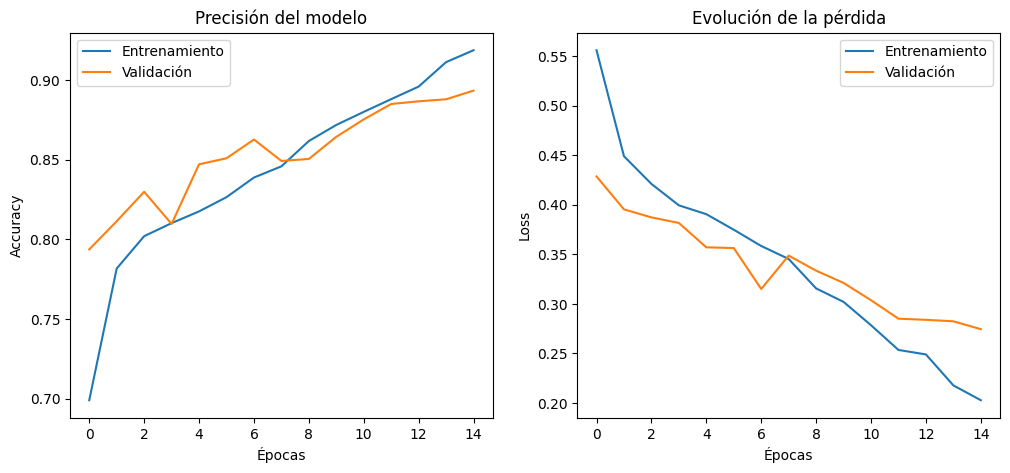

63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 153ms/step


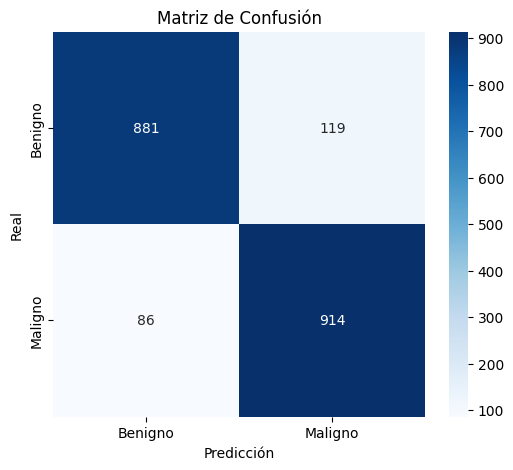


üìä Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

     Benigno       0.91      0.88      0.90      1000
     Maligno       0.88      0.91      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 214ms/step


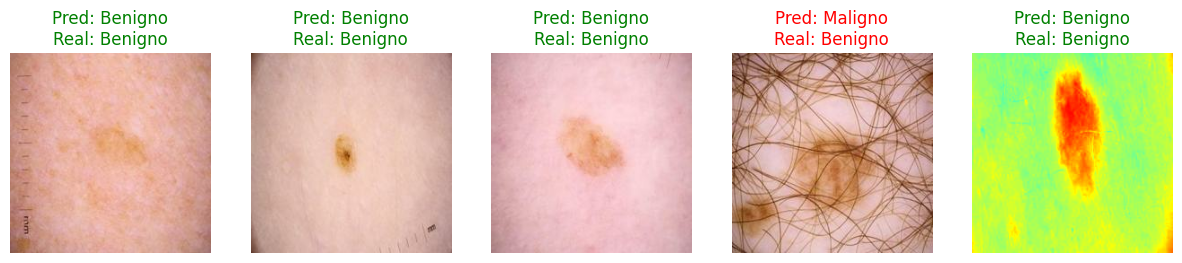

‚úÖ Modelo guardado como modelo_cnn.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# ===========================================================
# 1Ô∏è‚É£ Obtener nombres de clases (a partir de test_ds o train_dir)
# ===========================================================
class_names = test_ds.class_names if hasattr(test_ds, "class_names") else [
    "Benigno", "Maligno"
]
print("Clases detectadas:", class_names)

# ===========================================================
# 2Ô∏è‚É£ Calcular pesos de clase para balancear dataset
# ===========================================================
y_train_list = []
for _, y in train_ds.unbatch():
    y_train_list.append(y.numpy())
y_train = np.array(y_train_list)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

# ===========================================================
# 3Ô∏è‚É£ Crear el modelo CNN
# ===========================================================
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # üëà Clasificaci√≥n binaria
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

# ===========================================================
# 4Ô∏è‚É£ Entrenamiento
# ===========================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights
)

# ===========================================================
# 5Ô∏è‚É£ Evaluaci√≥n en test
# ===========================================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"‚úÖ Precisi√≥n en test: {test_acc:.2f}")

# ===========================================================
# 6Ô∏è‚É£ Gr√°ficas de Accuracy y Loss
# ===========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title("Precisi√≥n del modelo")
plt.xlabel("√âpocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title("Evoluci√≥n de la p√©rdida")
plt.xlabel("√âpocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ===========================================================
# 7Ô∏è‚É£ Matriz de confusi√≥n y reporte de clasificaci√≥n
# ===========================================================
y_true_list = []
for _, y in test_ds.unbatch():
    y_true_list.append(y.numpy())
y_true = np.array(y_true_list)

y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n")
plt.show()

print("\nüìä Reporte de Clasificaci√≥n:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# 8Ô∏è‚É£ Mostrar 5 im√°genes aleatorias con su predicci√≥n
# ===========================================================
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow((images[idx].numpy() * 255).astype("uint8"))  # ‚úÖ corregido
        plt.axis("off")
        color = "green" if preds_classes[idx] == int(labels[idx]) else "red"
        plt.title(f"Pred: {class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color)
plt.show()


# ===========================================================
# 9Ô∏è‚É£ Guardar modelo
# ===========================================================
model.save("modelo_cnn.h5")
print("‚úÖ Modelo guardado como modelo_cnn.h5")


## MODELO 2
He cambiado: 
- primera capa de 32 a 64 filtros 
- Aumentamos el Dropout a 0.65
- Cambio el optimizador de Adam a RMSprop
- HE bajado learning rate de 0.001 que es el predeterminado a 0.0005 

Clases detectadas: ['Benigno', 'Maligno']
Pesos de clase: {0: np.float64(0.9457603503184714), 1: np.float64(1.0608394730966733)}


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d_36 (Conv2D)              ‚îÇ (None, 224, 224, 64)   ‚îÇ         1,792 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_37 (Conv2D)              ‚îÇ (None, 224, 224, 64)   ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_18 (MaxPooling2D) ‚îÇ (None, 112, 112, 64)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_38 (Conv2D)              ‚îÇ (None, 112, 112, 64)   ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_39 (Conv2D)              ‚îÇ (None, 112, 112, 64)   ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_19 (MaxPooling2D) ‚îÇ (None, 56, 56, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_40 (Conv2D)              ‚îÇ (None, 56, 56, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_41 (Conv2D)              ‚îÇ (None, 56, 56, 128)    ‚îÇ       147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_20 (MaxPooling2D) ‚îÇ (None, 28, 28, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_6 (Flatten)             ‚îÇ (None, 100352)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_12 (Dense)                ‚îÇ (None, 256)            ‚îÇ    25,690,368 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ

 Total params: 26,024,641 (99.28 MB)

 Trainable params: 26,024,641 (99.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 286s 961ms/step - accuracy: 0.6778 - loss: 0.5896 - val_accuracy: 0.7765 - val_loss: 0.4813
Epoch 2/26
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 285s 961ms/step - accuracy: 0.7871 - loss: 0.4632 - val_accuracy: 0.8098 - val_loss: 0.4012
Epoch 3/26
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 283s 952ms/step - accuracy: 0.8022 - loss: 0.4317 - val_accuracy: 0.8056 - val_loss: 0.3912
Epoch 4/26
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 275s 925ms/step - accuracy: 0.8068 - loss: 0.4160 - val_accuracy: 0.8110 - val_loss: 0.3899
Epoch 5/26
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 272s 917ms/step - accuracy: 0.8232 - loss: 0.3941 - val_accuracy: 0.8215 - val_loss: 0.3762
Epoch 6/26
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 275s 925ms/step - accuracy: 0.8356 - loss: 0.3686 - val_accu

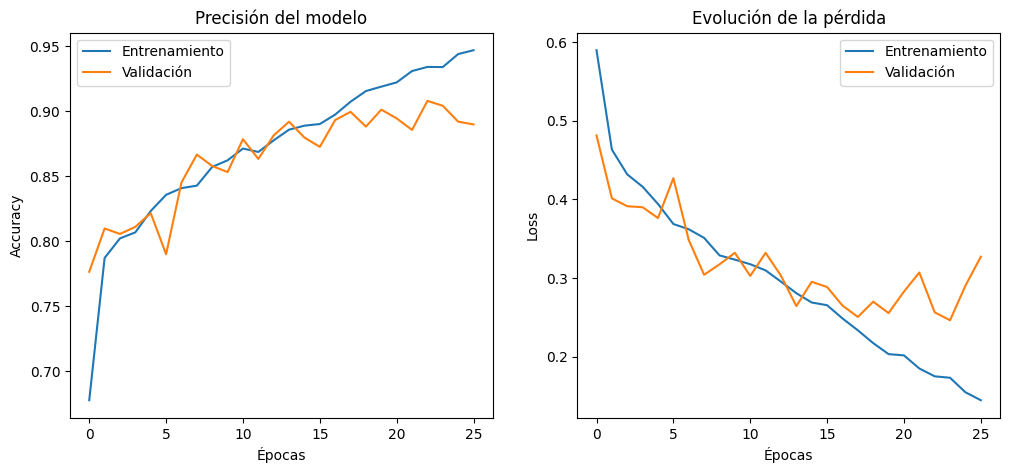

63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 284ms/step


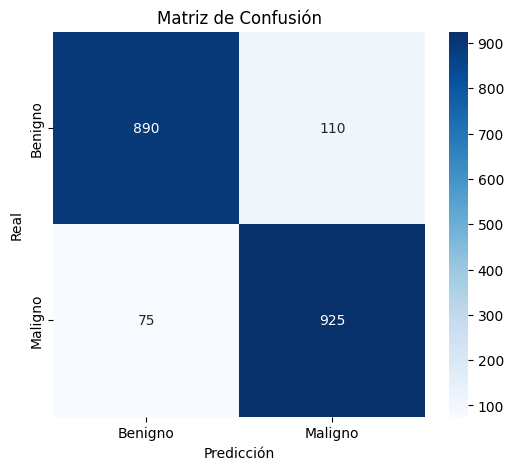


üìä Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

     Benigno       0.92      0.89      0.91      1000
     Maligno       0.89      0.93      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 385ms/step


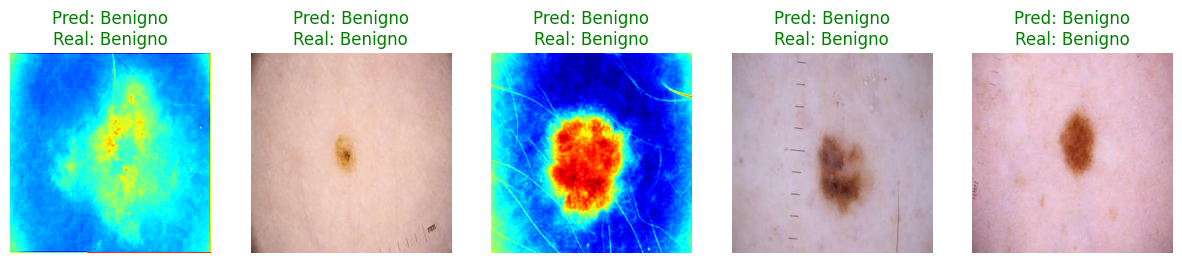

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# ===========================================================
# 1Ô∏è‚É£ Obtener nombres de clases (a partir de test_ds o train_dir)
# ===========================================================
class_names = test_ds.class_names if hasattr(test_ds, "class_names") else [
    "Benigno", "Maligno"
]
print("Clases detectadas:", class_names)

# ===========================================================
# 2Ô∏è‚É£ Calcular pesos de clase para balancear dataset
# ===========================================================
y_train_list = []
for _, y in train_ds.unbatch():
    y_train_list.append(y.numpy())
y_train = np.array(y_train_list)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

# ===========================================================
# 3Ô∏è‚É£ Crear el modelo CNN
# ===========================================================
model = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.65),
    layers.Dense(1, activation='sigmoid')  # üëà Clasificaci√≥n binaria
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=0.0005,  
        rho=0.9,
        momentum=0.0
    ),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ===========================================================
# 4Ô∏è‚É£ Entrenamiento
# ===========================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=26,
    class_weight=class_weights
)

# ===========================================================
# 5Ô∏è‚É£ Evaluaci√≥n en test
# ===========================================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"‚úÖ Precisi√≥n en test: {test_acc:.2f}")

# ===========================================================
# 6Ô∏è‚É£ Gr√°ficas de Accuracy y Loss
# ===========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title("Precisi√≥n del modelo")
plt.xlabel("√âpocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title("Evoluci√≥n de la p√©rdida")
plt.xlabel("√âpocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ===========================================================
# 7Ô∏è‚É£ Matriz de confusi√≥n y reporte de clasificaci√≥n
# ===========================================================
y_true_list = []
for _, y in test_ds.unbatch():
    y_true_list.append(y.numpy())
y_true = np.array(y_true_list)

y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n")
plt.show()

print("\nüìä Reporte de Clasificaci√≥n:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# 8Ô∏è‚É£ Mostrar 5 im√°genes aleatorias con su predicci√≥n
# ===========================================================
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow((images[idx].numpy() * 255).astype("uint8"))  # ‚úÖ corregido
        plt.axis("off")
        color = "green" if preds_classes[idx] == int(labels[idx]) else "red"
        plt.title(f"Pred: {class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color)
plt.show()

# ===========================================================
# 9Ô∏è‚É£ Guardar modelo
model.save("modelo2_cnn.h5")


## Modelo 3 

He cambiado: 
- Numero de filtros, al doble comparado con el Modelo 1
- He subido el learning rate comparado con el modelo 2, ahora es como el modelo 1
- Dropout de 0.6

Clases detectadas: ['Benigno', 'Maligno']
Pesos de clase: {0: np.float64(0.9440691436518974), 1: np.float64(1.0629753914988815)}


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d_42 (Conv2D)              ‚îÇ (None, 224, 224, 64)   ‚îÇ         1,792 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_43 (Conv2D)              ‚îÇ (None, 224, 224, 64)   ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_21 (MaxPooling2D) ‚îÇ (None, 112, 112, 64)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_44 (Conv2D)              ‚îÇ (None, 112, 112, 128)  ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_45 (Conv2D)              ‚îÇ (None, 112, 112, 128)  ‚îÇ       147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_22 (MaxPooling2D) ‚îÇ (None, 56, 56, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_46 (Conv2D)              ‚îÇ (None, 56, 56, 256)    ‚îÇ       295,168 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_47 (Conv2D)              ‚îÇ (None, 56, 56, 256)    ‚îÇ       590,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_23 (MaxPooling2D) ‚îÇ (None, 28, 28, 256)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_7 (Flatten)             ‚îÇ (None, 200704)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_14 (Dense)                ‚îÇ (None, 512)            ‚îÇ   102,760,960 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ

 Total params: 103,906,881 (396.37 MB)

 Trainable params: 103,906,881 (396.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 624s 2s/step - accuracy: 0.5928 - loss: 0.7021 - val_accuracy: 0.6961 - val_loss: 0.5384
Epoch 2/26
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 636s 2s/step - accuracy: 0.7313 - loss: 0.5272 - val_accuracy: 0.8043 - val_loss: 0.4143
Epoch 3/26
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 635s 2s/step - accuracy: 0.7822 - loss: 0.4599 - val_accuracy: 0.7399 - val_loss: 0.4840
Epoch 4/26
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 635s 2s/step - accuracy: 0.7967 - loss: 0.4409 - val_accuracy: 0.7988 - val_loss: 0.4176
Epoch 5/26
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 635s 2s/step - accuracy: 0.8039 - loss: 0.4266 - val_accuracy: 0.8249 - val_loss: 0.4068
Epoch 6/26
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 636s 2s/step - accuracy: 0.8080 - loss: 0.4117 - val_accuracy: 0.8182 - val

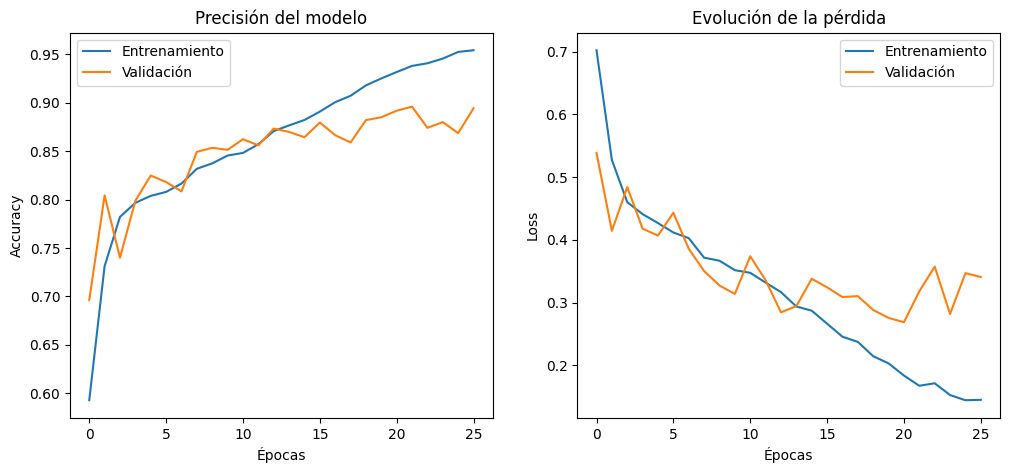

63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 33s 505ms/step


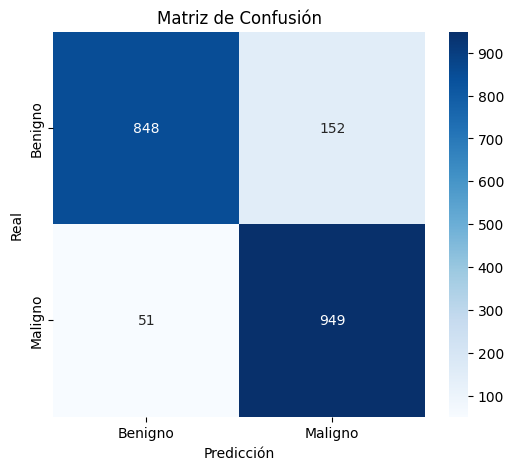


üìä Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

     Benigno       0.94      0.85      0.89      1000
     Maligno       0.86      0.95      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 562ms/step


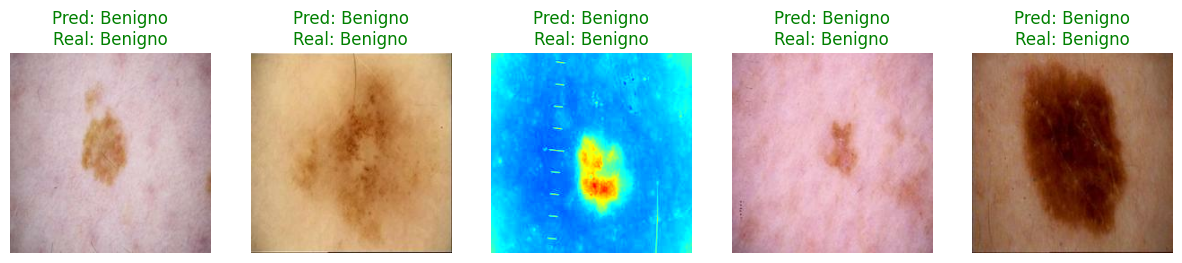

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# ===========================================================
# 1Ô∏è‚É£ Obtener nombres de clases (a partir de test_ds o train_dir)
# ===========================================================
class_names = test_ds.class_names if hasattr(test_ds, "class_names") else [
    "Benigno", "Maligno"
]
print("Clases detectadas:", class_names)

# ===========================================================
# 2Ô∏è‚É£ Calcular pesos de clase para balancear dataset
# ===========================================================
y_train_list = []
for _, y in train_ds.unbatch():
    y_train_list.append(y.numpy())
y_train = np.array(y_train_list)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

# ===========================================================
# 3Ô∏è‚É£ Crear el modelo CNN
# ===========================================================
model = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(1, activation='sigmoid')  # üëà Clasificaci√≥n binaria
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=0.001,  
        rho=0.9,
        momentum=0.0
    ),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ===========================================================
# 4Ô∏è‚É£ Entrenamiento
# ===========================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=26,
    class_weight=class_weights
)

# ===========================================================
# 5Ô∏è‚É£ Evaluaci√≥n en test
# ===========================================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"‚úÖ Precisi√≥n en test: {test_acc:.2f}")

# ===========================================================
# 6Ô∏è‚É£ Gr√°ficas de Accuracy y Loss
# ===========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title("Precisi√≥n del modelo")
plt.xlabel("√âpocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title("Evoluci√≥n de la p√©rdida")
plt.xlabel("√âpocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ===========================================================
# 7Ô∏è‚É£ Matriz de confusi√≥n y reporte de clasificaci√≥n
# ===========================================================
y_true_list = []
for _, y in test_ds.unbatch():
    y_true_list.append(y.numpy())
y_true = np.array(y_true_list)

y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n")
plt.show()

print("\nüìä Reporte de Clasificaci√≥n:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# 8Ô∏è‚É£ Mostrar 5 im√°genes aleatorias con su predicci√≥n
# ===========================================================
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow((images[idx].numpy() * 255).astype("uint8"))  # ‚úÖ corregido
        plt.axis("off")
        color = "green" if preds_classes[idx] == int(labels[idx]) else "red"
        plt.title(f"Pred: {class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color)
plt.show()

# ===========================================================
# 9Ô∏è‚É£ Guardar modelo
model.save("modelo3_cnn.h5")


## Modelo 4 
- Bajado los filtros a los mismos que el primer modelo
- Learning rate menor, 0.0005
- Dropout de 0.725
- Hasta 17 epochs

Clases detectadas: ['Benigno', 'Maligno']
Pesos de clase: {0: np.float64(0.9427579365079365), 1: np.float64(1.0646426170737173)}


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 224, 224, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 224, 224, 32)   ‚îÇ         9,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 112, 112, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 112, 112, 64)   ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_3 (Conv2D)               ‚îÇ (None, 112, 112, 64)   ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)  ‚îÇ (None, 56, 56, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_4 (Conv2D)               ‚îÇ (None, 56, 56, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_5 (Conv2D)               ‚îÇ (None, 56, 56, 128)    ‚îÇ       147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)  ‚îÇ (None, 28, 28, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)               ‚îÇ (None, 100352)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 256)            ‚îÇ    25,690,368 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ

 Total params: 25,977,633 (99.10 MB)

 Trainable params: 25,977,633 (99.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 274s 917ms/step - accuracy: 0.6950 - loss: 0.5704 - val_accuracy: 0.7677 - val_loss: 0.4463
Epoch 2/25
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 261s 878ms/step - accuracy: 0.7847 - loss: 0.4679 - val_accuracy: 0.8300 - val_loss: 0.3945
Epoch 3/25
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 252s 850ms/step - accuracy: 0.8000 - loss: 0.4433 - val_accuracy: 0.7769 - val_loss: 0.4232
Epoch 4/25
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 251s 844ms/step - accuracy: 0.8091 - loss: 0.4177 - val_accuracy: 0.8316 - val_loss: 0.3884
Epoch 5/25
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 256s 861ms/step - accuracy: 0.8095 - loss: 0.4093 - val_accuracy: 0.8489 - val_loss: 0.3412
Epoch 6/25
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 255s 859ms/step - accuracy: 0.8253 - loss: 0.3945 - val_accu

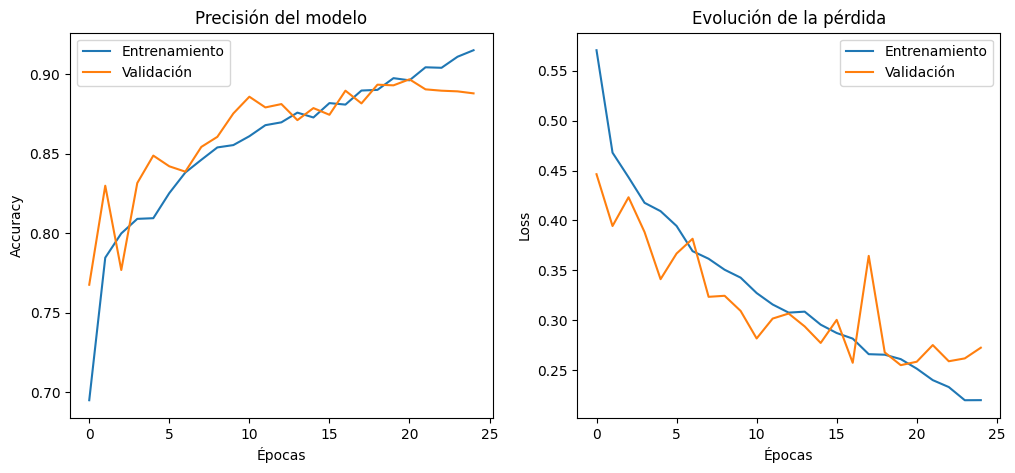

63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 157ms/step


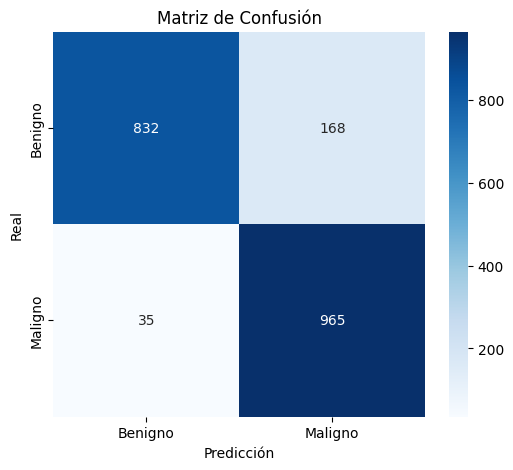


üìä Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

     Benigno       0.96      0.83      0.89      1000
     Maligno       0.85      0.96      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.90      0.90      2000

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 201ms/step


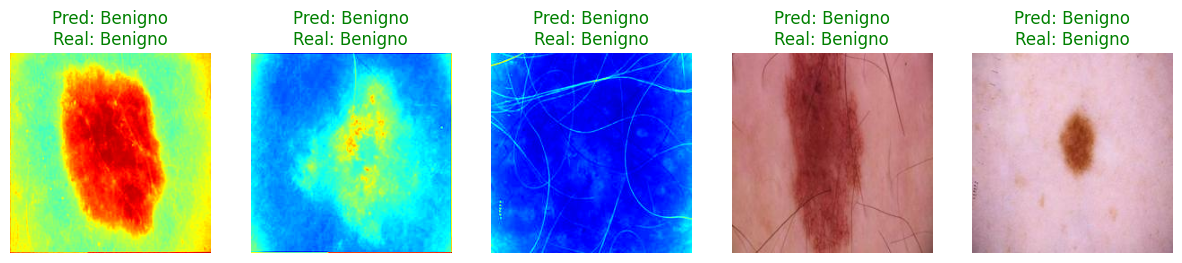

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# ===========================================================
# 1Ô∏è‚É£ Obtener nombres de clases (a partir de test_ds o train_dir)
# ===========================================================
class_names = test_ds.class_names if hasattr(test_ds, "class_names") else [
    "Benigno", "Maligno"
]
print("Clases detectadas:", class_names)

# ===========================================================
# 2Ô∏è‚É£ Calcular pesos de clase para balancear dataset
# ===========================================================
y_train_list = []
for _, y in train_ds.unbatch():
    y_train_list.append(y.numpy())
y_train = np.array(y_train_list)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

# ===========================================================
# 3Ô∏è‚É£ Crear el modelo CNN
# ===========================================================
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.725),
    layers.Dense(1, activation='sigmoid')  # üëà Clasificaci√≥n binaria
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=0.0005,  
        rho=0.9,
        momentum=0.0
    ),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ===========================================================
# 4Ô∏è‚É£ Entrenamiento
# ===========================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    class_weight=class_weights
)

# ===========================================================
# 5Ô∏è‚É£ Evaluaci√≥n en test
# ===========================================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"‚úÖ Precisi√≥n en test: {test_acc:.2f}")

# ===========================================================
# 6Ô∏è‚É£ Gr√°ficas de Accuracy y Loss
# ===========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title("Precisi√≥n del modelo")
plt.xlabel("√âpocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title("Evoluci√≥n de la p√©rdida")
plt.xlabel("√âpocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ===========================================================
# 7Ô∏è‚É£ Matriz de confusi√≥n y reporte de clasificaci√≥n
# ===========================================================
y_true_list = []
for _, y in test_ds.unbatch():
    y_true_list.append(y.numpy())
y_true = np.array(y_true_list)

y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n")
plt.show()

print("\nüìä Reporte de Clasificaci√≥n:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# 8Ô∏è‚É£ Mostrar 5 im√°genes aleatorias con su predicci√≥n
# ===========================================================
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow((images[idx].numpy() * 255).astype("uint8"))  # ‚úÖ corregido
        plt.axis("off")
        color = "green" if preds_classes[idx] == int(labels[idx]) else "red"
        plt.title(f"Pred: {class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color)
plt.show()

# ===========================================================
# 9Ô∏è‚É£ Guardar modelo
model.save("modelo4_cnn.h5")


## Modelo 5
- Igual que el modelo 4 en cuanto a filtro droput...
- Le metemos una aumentacion de datos para una mejor presici√≥n.


Clases detectadas: ['Benigno', 'Maligno']
Pesos de clase: {0: np.float64(0.9435067513899921), 1: np.float64(1.0636892769196329)}


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ sequential_1 (Sequential)       ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_6 (Conv2D)               ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_7 (Conv2D)               ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_3 (MaxPooling2D)  ‚îÇ ?                      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_8 (Conv2D)               ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_9 (Conv2D)               ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_4 (MaxPooling2D)  ‚îÇ ?                      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_10 (Conv2D)              ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_11 (Conv2D)              ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_5 (MaxPooling2D)  ‚îÇ ?                      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_1 (Flatten)             ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 174s 580ms/step - accuracy: 0.5052 - loss: 0.9576 - val_accuracy: 0.5244 - val_loss: 0.6930
Epoch 2/25
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 175s 588ms/step - accuracy: 0.5038 - loss: 0.6941 - val_accuracy: 0.4735 - val_loss: 0.6938
Epoch 3/25
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 176s 593ms/step - accuracy: 0.5131 - loss: 0.6934 - val_accuracy: 0.4777 - val_loss: 0.6934
Epoch 4/25
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 168s 566ms/step - accuracy: 0.5087 - loss: 0.6959 - val_accuracy: 0.5261 - val_loss: 0.6930
Epoch 5/25
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 171s 576ms/step - accuracy: 0.5142 - loss: 0.6931 - val_accuracy: 0.5278 - val_loss: 0.6930
Epoch 6/25
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 175s 590ms/step - accuracy: 0.5076 - loss: 0.6933 - val_accu

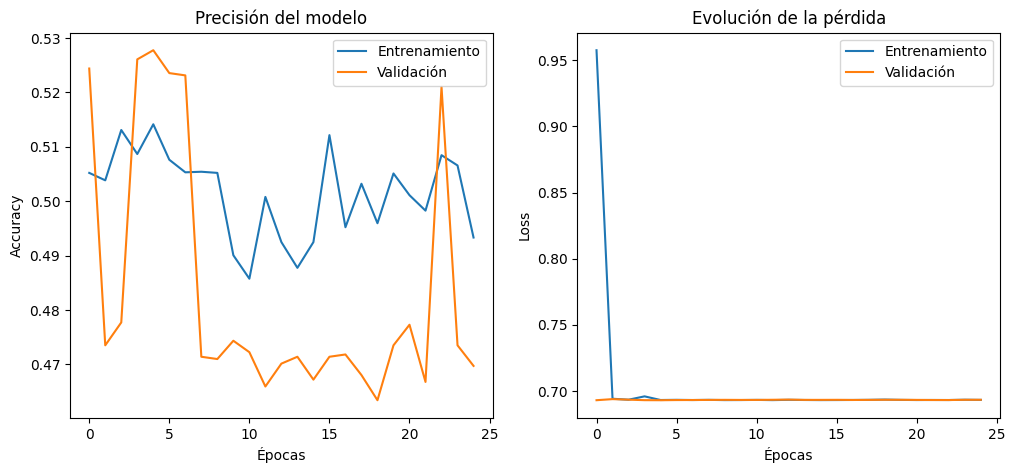

63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 152ms/step


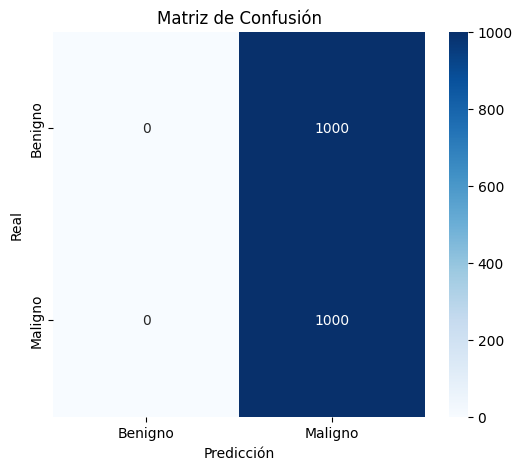


üìä Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

     Benigno       0.00      0.00      0.00      1000
     Maligno       0.50      1.00      0.67      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 208ms/step


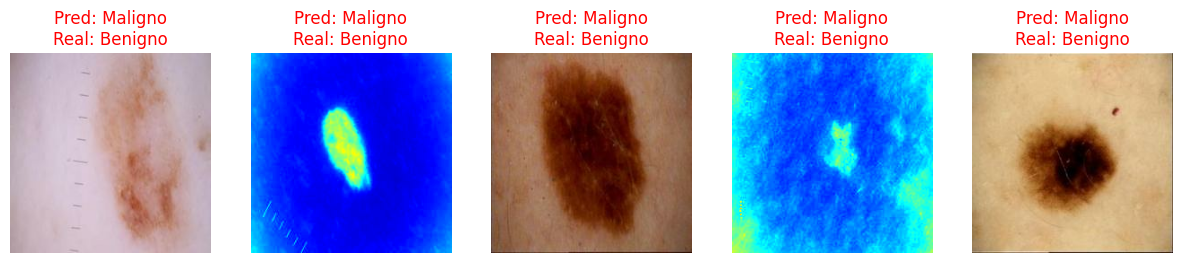

TypeError: cannot pickle 'module' object

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# ===========================================================
# 1Ô∏è‚É£ Obtener nombres de clases (a partir de test_ds o train_dir)
# ===========================================================
class_names = test_ds.class_names if hasattr(test_ds, "class_names") else [
    "Benigno", "Maligno"
]
print("Clases detectadas:", class_names)

# ===========================================================
# 2Ô∏è‚É£ Calcular pesos de clase para balancear dataset
# ===========================================================
y_train_list = []
for _, y in train_ds.unbatch():
    y_train_list.append(y.numpy())
y_train = np.array(y_train_list)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

# ===========================================================
# üîπ AUMENTACI√ìN DE DATOS (Data Augmentation)
# ===========================================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Volteos aleatorios
    layers.RandomRotation(0.1),                    # Rotaci√≥n +/-10%
    layers.RandomZoom(0.1),                        # Zoom aleatorio
    layers.RandomContrast(0.2),                    # Contraste variable
    layers.RandomBrightness(factor=0.1)            # Brillo variable
])

# ===========================================================
# 3Ô∏è‚É£ Crear el modelo CNN (con data augmentation)
# ===========================================================
model = models.Sequential([
    data_augmentation,  # üëà nueva capa al inicio
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.725),
    layers.Dense(1, activation='sigmoid')  # Clasificaci√≥n binaria
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=0.0005,  
        rho=0.9,
        momentum=0.0
    ),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ===========================================================
# 4Ô∏è‚É£ Entrenamiento
# ===========================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    class_weight=class_weights
)

# ===========================================================
# 5Ô∏è‚É£ Evaluaci√≥n en test
# ===========================================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"‚úÖ Precisi√≥n en test: {test_acc:.2f}")

# ===========================================================
# 6Ô∏è‚É£ Gr√°ficas de Accuracy y Loss
# ===========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title("Precisi√≥n del modelo")
plt.xlabel("√âpocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title("Evoluci√≥n de la p√©rdida")
plt.xlabel("√âpocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ===========================================================
# 7Ô∏è‚É£ Matriz de confusi√≥n y reporte de clasificaci√≥n
# ===========================================================
y_true_list = []
for _, y in test_ds.unbatch():
    y_true_list.append(y.numpy())
y_true = np.array(y_true_list)

y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n")
plt.show()

print("\nüìä Reporte de Clasificaci√≥n:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# 8Ô∏è‚É£ Mostrar 5 im√°genes aleatorias con su predicci√≥n
# ===========================================================
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow((images[idx].numpy() * 255).astype("uint8"))  # ‚úÖ corregido
        plt.axis("off")
        color = "green" if preds_classes[idx] == int(labels[idx]) else "red"
        plt.title(f"Pred: {class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color)
plt.show()

# ===========================================================
# 9Ô∏è‚É£ Guardar modelo
# ===========================================================
model.save("modelo5_cnn.h5")
print("‚úÖ Modelo guardado con data augmentation incluido.")


## Posible modelo final

In [5]:
# ===========================================================
# üî• BLOQUE 2 ‚Äî MODELO, ENTRENAMIENTO Y EVALUACI√ìN MEJORADO
# ===========================================================
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os
import datetime

# -----------------------------------------------------------
# Configuraci√≥n base
# -----------------------------------------------------------
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Par√°metros de entrenamiento
base_lr = 1e-3
fine_tune_lr = 1e-4
initial_epochs = 10
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# ===========================================================
# 1Ô∏è‚É£ Obtener nombres de clases
# ===========================================================
class_names = test_ds.class_names if hasattr(test_ds, "class_names") else ["Benigno", "Maligno"]
print("Clases detectadas:", class_names)

# ===========================================================
# 2Ô∏è‚É£ Calcular pesos de clase (para dataset desbalanceado)
# ===========================================================
y_train_list = []
for _, y in train_ds.unbatch():
    y_train_list.append(y.numpy())
y_train = np.array(y_train_list)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

# ===========================================================
# 3Ô∏è‚É£ Crear el modelo base (Transfer Learning)
# ===========================================================
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(img_height, img_width, 3),
    weights="imagenet"
)
base_model.trainable = False  # congelar inicialmente

# Bloque superior del modelo
inputs = layers.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs, name="EfficientNetB0_binary")

# ===========================================================
# 4Ô∏è‚É£ Compilaci√≥n del modelo
# ===========================================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="AUC"),
        tf.keras.metrics.Precision(name="Precision"),
        tf.keras.metrics.Recall(name="Recall")
    ]
)

model.summary()

# ===========================================================
# 5Ô∏è‚É£ Callbacks
# ===========================================================
log_dir = os.path.join(output_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_AUC",
        patience=6,
        mode="max",
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(output_dir, "best_model.h5"),
        monitor="val_AUC",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir)
]

# ===========================================================
# 6Ô∏è‚É£ Entrenamiento Fase 1 (solo la cabeza)
# ===========================================================
print("\nüöÄ Entrenando la parte superior (base congelada)...")
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    class_weight=class_weights,
    callbacks=callbacks
)

# ===========================================================
# 7Ô∏è‚É£ Fine-Tuning (descongelar parte de EfficientNet)
# ===========================================================
fine_tune_at = int(len(base_model.layers) * 0.75)
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= fine_tune_at

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print(f"\nüîß Fine-tuning activado desde la capa {fine_tune_at}/{len(base_model.layers)}")

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history1.epoch[-1] + 1,
    class_weight=class_weights,
    callbacks=callbacks
)

# ===========================================================
# 8Ô∏è‚É£ Evaluaci√≥n en test
# ===========================================================
print("\nüìä Evaluando en el conjunto de test...")
test_loss, test_acc, test_auc, test_prec, test_rec = model.evaluate(test_ds, return_dict=False)
print(f"\n‚úÖ Test Accuracy: {test_acc:.4f} | AUC: {test_auc:.4f} | Precision: {test_prec:.4f} | Recall: {test_rec:.4f}")

# ===========================================================
# 9Ô∏è‚É£ M√©tricas visuales
# ===========================================================
def plot_history(histories):
    plt.figure(figsize=(14, 5))
    for key in ["accuracy", "AUC"]:
        plt.subplot(1, 2, 1)
        for h in histories:
            plt.plot(h.history[key], label=f"{key} (train)")
            plt.plot(h.history[f"val_{key}"], label=f"{key} (val)")
        plt.title(f"Evoluci√≥n de {key}")
        plt.xlabel("√âpocas")
        plt.legend()

    plt.subplot(1, 2, 2)
    for h in histories:
        plt.plot(h.history["loss"], label="Entrenamiento")
        plt.plot(h.history["val_loss"], label="Validaci√≥n")
    plt.title("P√©rdida (Loss)")
    plt.xlabel("√âpocas")
    plt.legend()
    plt.show()

plot_history([history1, history2])

# ===========================================================
# üîü Matriz de confusi√≥n y reporte de clasificaci√≥n
# ===========================================================
y_true_list = []
for _, y in test_ds.unbatch():
    y_true_list.append(y.numpy())
y_true = np.array(y_true_list)

y_pred_prob = model.predict(test_ds)
threshold = 0.5
y_pred = (y_pred_prob.flatten() > threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n")
plt.show()

print("\nüìà Reporte de Clasificaci√≥n:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# 1Ô∏è‚É£1Ô∏è‚É£ Mostrar 5 im√°genes aleatorias con predicci√≥n
# ===========================================================
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow((images[idx].numpy() * 255).astype("uint8"))
        plt.axis("off")
        color = "green" if preds_classes[idx] == int(labels[idx]) else "red"
        plt.title(f"Pred: {class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color)
plt.show()

# ===========================================================
# 1Ô∏è‚É£2Ô∏è‚É£ Guardar modelo final
# ===========================================================
model.save(os.path.join(output_dir, "modelo_final_efficientnet.h5"))
print(f"\nüíæ Modelo guardado en: {os.path.join(output_dir, 'modelo_final_efficientnet.h5')}")


Clases detectadas: ['Benigno', 'Maligno']
Pesos de clase: {0: np.float64(0.9425709184685578), 1: np.float64(1.0648812191842223)}
16705208/16705208 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 52s 3us/step


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

## MODELO FINAL; ES EL MODELO 4

Clases detectadas: ['Benigno', 'Maligno']
Pesos de clase: {0: np.float64(0.9457603503184714), 1: np.float64(1.0608394730966733)}


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d_8 (Conv2D)               ‚îÇ (None, 224, 224, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_9 (Conv2D)               ‚îÇ (None, 224, 224, 32)   ‚îÇ         9,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_3 (MaxPooling2D)  ‚îÇ (None, 112, 112, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_10 (Conv2D)              ‚îÇ (None, 112, 112, 64)   ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_11 (Conv2D)              ‚îÇ (None, 112, 112, 64)   ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_4 (MaxPooling2D)  ‚îÇ (None, 56, 56, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_12 (Conv2D)              ‚îÇ (None, 56, 56, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_13 (Conv2D)              ‚îÇ (None, 56, 56, 128)    ‚îÇ       147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_5 (MaxPooling2D)  ‚îÇ (None, 28, 28, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)               ‚îÇ (None, 100352)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                 ‚îÇ (None, 256)            ‚îÇ    25,690,368 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ

 Total params: 25,977,633 (99.10 MB)

 Trainable params: 25,977,633 (99.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 218s 731ms/step - accuracy: 0.4939 - loss: 0.7661 - val_accuracy: 0.4697 - val_loss: 0.6935
Epoch 2/20
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 217s 728ms/step - accuracy: 0.4979 - loss: 0.6974 - val_accuracy: 0.5227 - val_loss: 0.6931
Epoch 3/20
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 218s 734ms/step - accuracy: 0.5024 - loss: 0.6955 - val_accuracy: 0.5278 - val_loss: 0.6929
Epoch 4/20
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 210s 707ms/step - accuracy: 0.5090 - loss: 0.6934 - val_accuracy: 0.4684 - val_loss: 0.6932
Epoch 5/20
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 205s 689ms/step - accuracy: 0.5132 - loss: 0.6934 - val_accuracy: 0.4747 - val_loss: 0.6932
Epoch 6/20
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 204s 687ms/step - accuracy: 0.5073 - loss: 0.6932 - val_accu

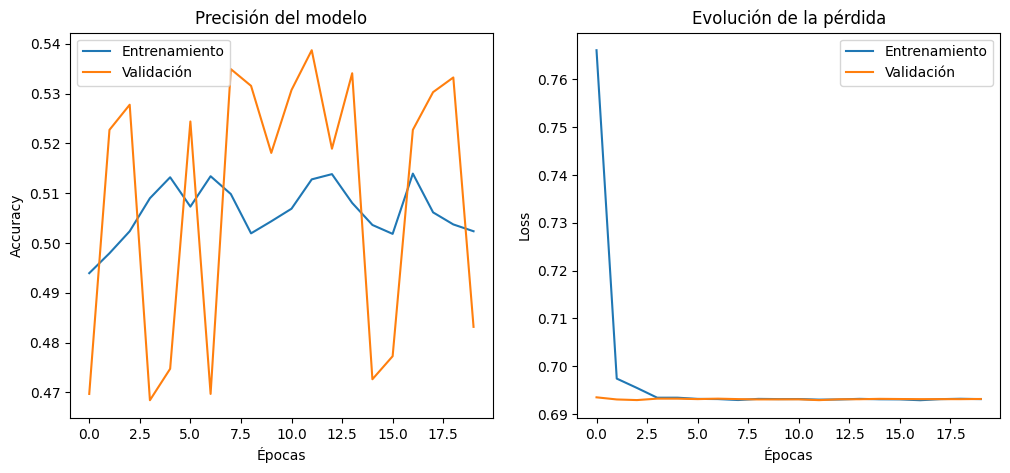

63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 148ms/step


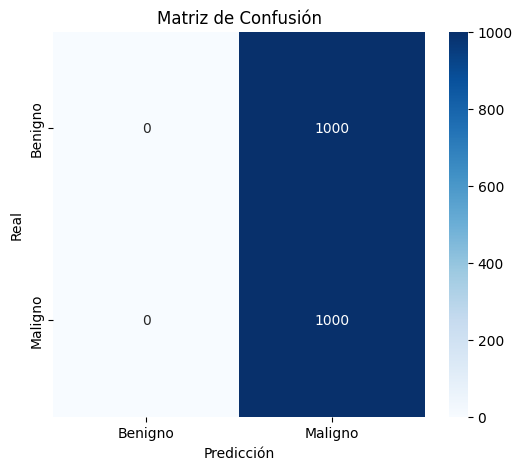


üìä Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

     Benigno       0.00      0.00      0.00      1000
     Maligno       0.50      1.00      0.67      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 227ms/step


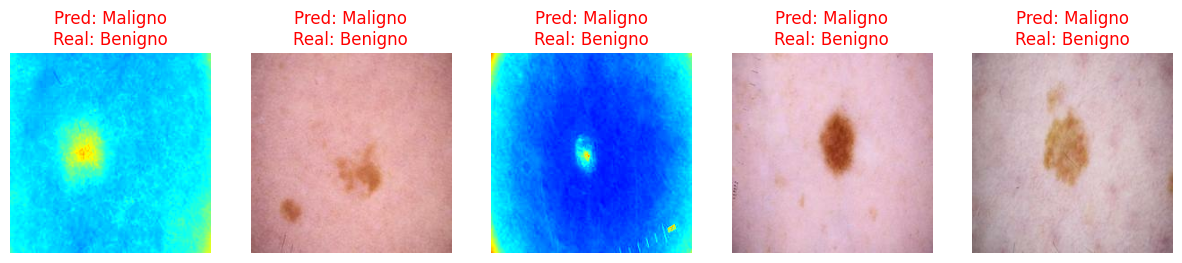

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# ===========================================================
# 1Ô∏è‚É£ Obtener nombres de clases (a partir de test_ds o train_dir)
# ===========================================================
class_names = test_ds.class_names if hasattr(test_ds, "class_names") else [
    "Benigno", "Maligno"
]
print("Clases detectadas:", class_names)

# ===========================================================
# 2Ô∏è‚É£ Calcular pesos de clase para balancear dataset
# ===========================================================
y_train_list = []
for _, y in train_ds.unbatch():
    y_train_list.append(y.numpy())
y_train = np.array(y_train_list)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

# ===========================================================
# 3Ô∏è‚É£ Crear el modelo CNN
# ===========================================================
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.725),
    layers.Dense(1, activation='sigmoid')  # üëà Clasificaci√≥n binaria
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=0.0005,  
        rho=0.9,
        momentum=0.0
    ),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ===========================================================
# 4Ô∏è‚É£ Entrenamiento
# ===========================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights
)

# ===========================================================
# 5Ô∏è‚É£ Evaluaci√≥n en test
# ===========================================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"‚úÖ Precisi√≥n en test: {test_acc:.2f}")

# ===========================================================
# 6Ô∏è‚É£ Gr√°ficas de Accuracy y Loss
# ===========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title("Precisi√≥n del modelo")
plt.xlabel("√âpocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title("Evoluci√≥n de la p√©rdida")
plt.xlabel("√âpocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ===========================================================
# 7Ô∏è‚É£ Matriz de confusi√≥n y reporte de clasificaci√≥n
# ===========================================================
y_true_list = []
for _, y in test_ds.unbatch():
    y_true_list.append(y.numpy())
y_true = np.array(y_true_list)

y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n")
plt.show()

print("\nüìä Reporte de Clasificaci√≥n:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# 8Ô∏è‚É£ Mostrar 5 im√°genes aleatorias con su predicci√≥n
# ===========================================================
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow((images[idx].numpy() * 255).astype("uint8"))  # ‚úÖ corregido
        plt.axis("off")
        color = "green" if preds_classes[idx] == int(labels[idx]) else "red"
        plt.title(f"Pred: {class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color)
plt.show()



## MODELO FINAL 

Clases detectadas: ['Benigno', 'Maligno']
Pesos de clase: {0: np.float64(0.9427579365079365), 1: np.float64(1.0646426170737173)}


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 224, 224, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 224, 224, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 224, 224, 32)   ‚îÇ         9,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 224, 224, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 112, 112, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ spatial_dropout2d               ‚îÇ (None, 112, 112, 32)   ‚îÇ             0 ‚îÇ
‚îÇ (SpatialDropout2D)              ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 112, 112, 64)   ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 112, 112, 64)   ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_3 (Conv2D)               ‚îÇ (None, 112, 112, 64)   ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_3           ‚îÇ (None, 112, 112, 64)   ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 1,475,617 (5.63 MB)

 Trainable params: 1,471,905 (5.61 MB)

 Non-trainable params: 3,712 (14.50 KB)


--- ENTRENAMIENTO PRINCIPAL ---
Epoch 1/60
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.4980 - auc: 0.4972 - loss: 0.9316 - precision: 0.4551 - recall: 0.4818
Epoch 1: val_accuracy improved from None to 0.42803, saving model to best_cnn_skin_cancer.h5


297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 421s 1s/step - accuracy: 0.4950 - auc: 0.4966 - loss: 0.8669 - precision: 0.4634 - recall: 0.4918 - val_accuracy: 0.4280 - val_auc: 0.4940 - val_loss: 0.6948 - val_precision: 0.2357 - val_recall: 0.0956 - learning_rate: 0.0010
Epoch 2/60
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5048 - auc: 0.4978 - loss: 0.7715 - precision: 0.4755 - recall: 0.5006
Epoch 2: val_accuracy improved from 0.42803 to 0.53157, saving model to best_cnn_skin_cancer.h5


297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 441s 1s/step - accuracy: 0.5064 - auc: 0.5048 - loss: 0.7514 - precision: 0.4764 - recall: 0.5021 - val_accuracy: 0.5316 - val_auc: 0.3895 - val_loss: 0.7015 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/60
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.4909 - auc: 0.4898 - loss: 0.7277 - precision: 0.4637 - recall: 0.5032
Epoch 3: val_accuracy did not improve from 0.53157
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 417s 1s/step - accuracy: 0.4990 - auc: 0.4974 - loss: 0.7182 - precision: 0.4708 - recall: 0.5016 - val_accuracy: 0.4705 - val_auc: 0.5834 - val_loss: 0.6955 - val_precision: 0.4705 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/60
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5000 - auc: 0.4968 - loss: 0.7075 - precision: 0.4655 - recall: 0.51

297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 424s 1s/step - accuracy: 0.4984 - auc: 0.5001 - loss: 0.6973 - precision: 0.4699 - recall: 0.5258 - val_accuracy: 0.6019 - val_auc: 0.6260 - val_loss: 0.6916 - val_precision: 0.7521 - val_recall: 0.2351 - learning_rate: 0.0010
Epoch 7/60
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.4939 - auc: 0.4966 - loss: 0.6961 - precision: 0.4634 - recall: 0.5164
Epoch 7: val_accuracy did not improve from 0.60185
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 423s 1s/step - accuracy: 0.4972 - auc: 0.4981 - loss: 0.6963 - precision: 0.4678 - recall: 0.5169 - val_accuracy: 0.5274 - val_auc: 0.6051 - val_loss: 0.6903 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 8/60
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5210 - auc: 0.5197 - loss: 0.6933 - precision: 0.4770 - recall: 0.45

297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 443s 1s/step - accuracy: 0.4913 - auc: 0.4902 - loss: 0.6958 - precision: 0.4619 - recall: 0.5154 - val_accuracy: 0.6494 - val_auc: 0.6342 - val_loss: 0.6894 - val_precision: 0.5859 - val_recall: 0.9056 - learning_rate: 5.0000e-04
Epoch 16/60
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5062 - auc: 0.5102 - loss: 0.6938 - precision: 0.4724 - recall: 0.4894
Epoch 16: val_accuracy did not improve from 0.64941
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 460s 2s/step - accuracy: 0.5077 - auc: 0.5093 - loss: 0.6944 - precision: 0.4763 - recall: 0.4718 - val_accuracy: 0.5358 - val_auc: 0.4426 - val_loss: 0.6931 - val_precision: 1.0000 - val_recall: 0.0290 - learning_rate: 5.0000e-04
Epoch 17/60
297/297 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 48s/step - accuracy: 0.5081 - auc: 0.5156 - loss: 0.6932 - precision: 0.4739 - recall: 

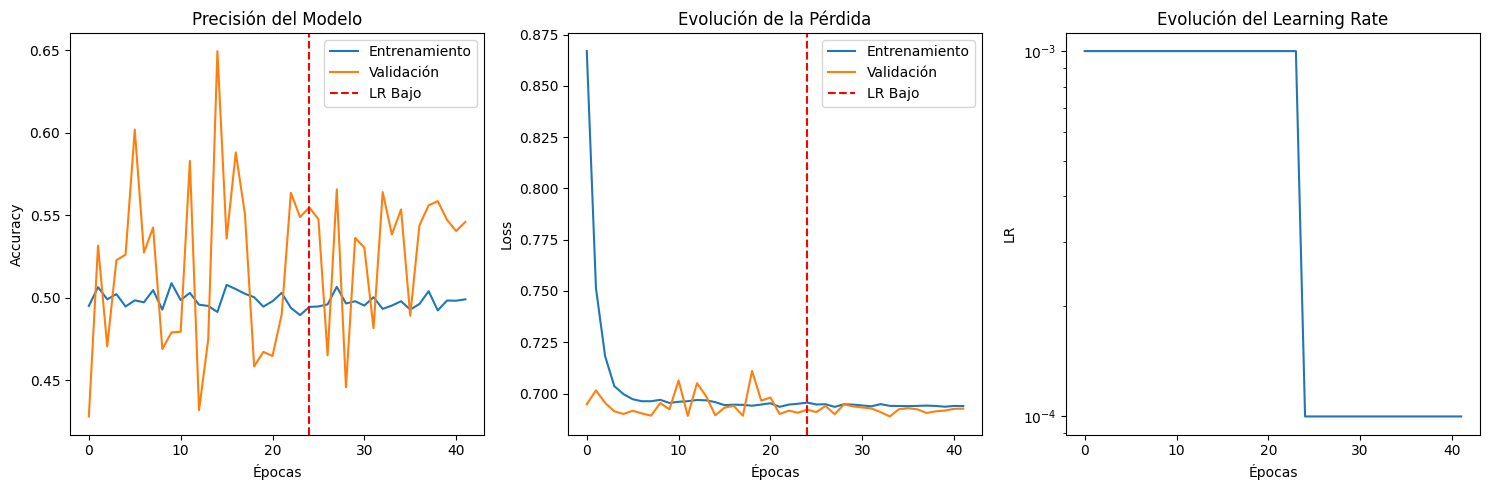


--- OPTIMIZACI√ìN DE THRESHOLD ---
üîç Threshold √≥ptimo encontrado: 0.300
üéØ F1-score en validaci√≥n: 0.6298
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 257ms/step


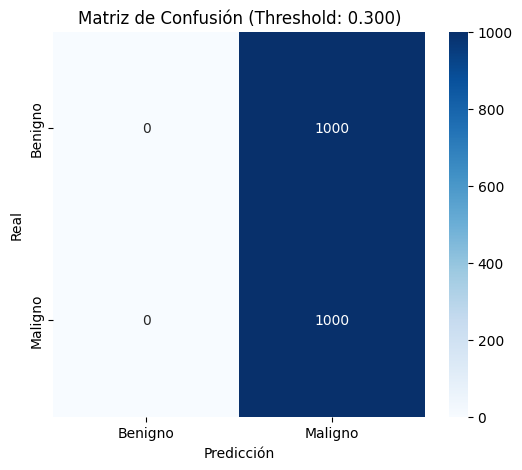


üìä REPORTE DE CLASIFICACI√ìN OPTIMIZADO:
              precision    recall  f1-score   support

     Benigno       0.00      0.00      0.00      1000
     Maligno       0.50      1.00      0.67      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

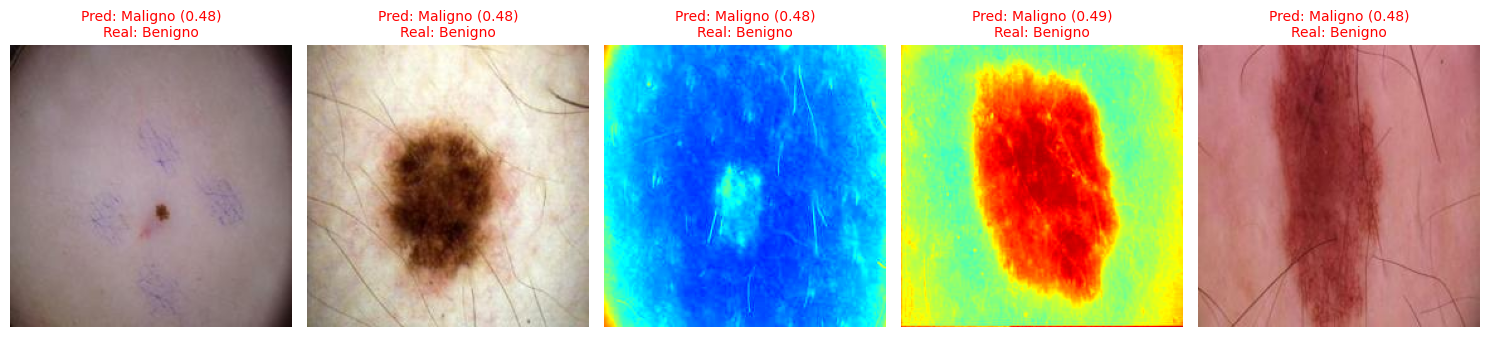

üíæ Modelo CNN guardado como 'cnn_skin_cancer_final.h5'


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# ===========================================================
# 1Ô∏è‚É£ Obtener nombres de clases
# ===========================================================
class_names = test_ds.class_names if hasattr(test_ds, "class_names") else [
    "Benigno", "Maligno"
]
print("Clases detectadas:", class_names)

# ===========================================================
# 2Ô∏è‚É£ Calcular pesos de clase para balancear dataset
# ===========================================================
y_train_list = []
for _, y in train_ds.unbatch():
    y_train_list.append(y.numpy())
y_train = np.array(y_train_list)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

# ===========================================================
# 3Ô∏è‚É£ Data Augmentation Mejorado
# ===========================================================
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
    layers.RandomFlip("horizontal"),
])

# Aplicar data augmentation al dataset de entrenamiento
def augment_data(x, y):
    return data_augmentation(x, training=True), y

train_ds = train_ds.map(augment_data)

# ===========================================================
# 4Ô∏è‚É£ Crear CNN mejorada desde cero
# ===========================================================
def create_improved_cnn():
    model = models.Sequential([
        # Bloque 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
        layers.BatchNormalization(),  # ‚úÖ NUEVO: Mejora convergencia
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),  # ‚úÖ NUEVO
        layers.MaxPooling2D(2,2),
        layers.SpatialDropout2D(0.25),  # ‚úÖ MEJORADO: SpatialDropout es mejor para conv
        
        # Bloque 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),  # ‚úÖ NUEVO
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),  # ‚úÖ NUEVO
        layers.MaxPooling2D(2,2),
        layers.SpatialDropout2D(0.3),  # ‚úÖ MEJORADO
        
        # Bloque 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),  # ‚úÖ NUEVO
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),  # ‚úÖ NUEVO
        layers.MaxPooling2D(2,2),
        layers.SpatialDropout2D(0.4),  # ‚úÖ MEJORADO
        
        # Bloque 4 - A√±adido nuevo bloque para mayor profundidad
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),  # ‚úÖ NUEVO
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),  # ‚úÖ NUEVO
        layers.GlobalAveragePooling2D(),  # ‚úÖ MEJORADO: En lugar de Flatten()
        
        # Capas fully connected
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),  # ‚úÖ NUEVO
        layers.Dropout(0.6),  # ‚úÖ AJUSTADO
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),  # ‚úÖ NUEVO
        layers.Dropout(0.5),  # ‚úÖ AJUSTADO
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),  # ‚úÖ NUEVO
        layers.Dropout(0.4),  # ‚úÖ AJUSTADO
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

model = create_improved_cnn()

# ===========================================================
# 5Ô∏è‚É£ Compilar con optimizador mejorado
# ===========================================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,  # ‚úÖ CAMBIADO: Adam es mejor que RMSprop
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    ),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

# ===========================================================
# 6Ô∏è‚É£ Callbacks para mejorar entrenamiento
# ===========================================================
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=12,           # ‚úÖ NUEVO: Para evitar overfitting
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,            # ‚úÖ NUEVO: Reduce LR cuando se estanca
        patience=6,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_cnn_skin_cancer.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# ===========================================================
# 7Ô∏è‚É£ Entrenamiento principal
# ===========================================================
print("\n--- ENTRENAMIENTO PRINCIPAL ---")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,                  # ‚úÖ AUMENTADO: M√°s √©pocas con early stopping
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# ===========================================================
# 8Ô∏è‚É£ Entrenamiento adicional con learning rate m√°s bajo (opcional)
# ===========================================================
print("\n--- ENTRENAMIENTO CON LR BAJO ---")

# Recompilar con learning rate m√°s bajo para ajuste fino
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # LR m√°s bajo
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

# Continuar entrenamiento
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=8, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-8)
    ],
    verbose=1
)

# ===========================================================
# 9Ô∏è‚É£ Evaluaci√≥n en test
# ===========================================================
print("\n--- EVALUACI√ìN FINAL ---")
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_ds)
print(f"‚úÖ Precisi√≥n en test: {test_acc:.4f}")
print(f"‚úÖ Precisi√≥n (Precision): {test_precision:.4f}")
print(f"‚úÖ Sensibilidad (Recall): {test_recall:.4f}")
print(f"‚úÖ AUC: {test_auc:.4f}")

# ===========================================================
# üîü Gr√°ficas de M√©tricas de Entrenamiento
# ===========================================================
plt.figure(figsize=(15,5))

# Precisi√≥n
plt.subplot(1,3,1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validaci√≥n')
plt.title("Precisi√≥n del Modelo")
plt.xlabel("√âpocas")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=len(history.history['accuracy']), color='r', linestyle='--', label='LR Bajo')
plt.legend()

# P√©rdida
plt.subplot(1,3,2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validaci√≥n')
plt.title("Evoluci√≥n de la P√©rdida")
plt.xlabel("√âpocas")
plt.ylabel("Loss")
plt.legend()
plt.axvline(x=len(history.history['loss']), color='r', linestyle='--', label='LR Bajo')
plt.legend()

# Learning Rate
plt.subplot(1,3,3)
lr_history = history.history.get('lr', [0.001] * len(history.history['loss'])) + \
             history_fine.history.get('lr', [0.0001] * len(history_fine.history['loss']))
plt.plot(lr_history)
plt.title("Evoluci√≥n del Learning Rate")
plt.xlabel("√âpocas")
plt.ylabel("LR")
plt.yscale('log')

plt.tight_layout()
plt.show()

# ===========================================================
# 1Ô∏è‚É£1Ô∏è‚É£ Encontrar Threshold √ìptimo
# ===========================================================
print("\n--- OPTIMIZACI√ìN DE THRESHOLD ---")

# Obtener predicciones en validation set
y_val_true = []
y_val_probs = []

for images, labels in val_ds.unbatch():
    y_val_true.append(labels.numpy())
    pred = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    y_val_probs.append(pred[0][0])

y_val_true = np.array(y_val_true)
y_val_probs = np.array(y_val_probs)

# Encontrar threshold √≥ptimo basado en F1-score
thresholds = np.arange(0.3, 0.7, 0.01)
f1_scores = [f1_score(y_val_true, (y_val_probs > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"üîç Threshold √≥ptimo encontrado: {best_threshold:.3f}")
print(f"üéØ F1-score en validaci√≥n: {max(f1_scores):.4f}")

# ===========================================================
# 1Ô∏è‚É£2Ô∏è‚É£ Matriz de Confusi√≥n y Reporte con Threshold √ìptimo
# ===========================================================
y_true_list = []
for _, y in test_ds.unbatch():
    y_true_list.append(y.numpy())
y_true = np.array(y_true_list)

y_pred_prob = model.predict(test_ds)
y_pred_optim = (y_pred_prob > best_threshold).astype("int32").flatten()

# Matriz de confusi√≥n
cm = confusion_matrix(y_true, y_pred_optim)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title(f"Matriz de Confusi√≥n (Threshold: {best_threshold:.3f})")
plt.show()

print("\nüìä REPORTE DE CLASIFICACI√ìN OPTIMIZADO:")
print(classification_report(y_true, y_pred_optim, target_names=class_names))

# ===========================================================
# 1Ô∏è‚É£3Ô∏è‚É£ Mostrar predicciones con threshold √≥ptimo
# ===========================================================
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images, verbose=0)
    preds_classes = (preds > best_threshold).astype("int32").flatten()
    preds_probs = preds.flatten()
    
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow((images[idx].numpy() * 255).astype("uint8"))
        plt.axis("off")
        
        color = "green" if preds_classes[idx] == int(labels[idx]) else "red"
        confidence = preds_probs[idx] if preds_classes[idx] == 1 else 1 - preds_probs[idx]
        
        plt.title(f"Pred: {class_names[preds_classes[idx]]} ({confidence:.2f})\nReal: {class_names[int(labels[idx])]}", 
                 color=color, fontsize=10)
plt.tight_layout()
plt.show()

# ===========================================================
# 1Ô∏è‚É£4Ô∏è‚É£ Guardar modelo final
# ===========================================================
model.save('cnn_skin_cancer_final.h5')
print("üíæ Modelo CNN guardado como 'cnn_skin_cancer_final.h5'")